##### aimldl >python3 > packages > tensorflow > tutorials > beginners > 1_3_3-overfit_and_underfit-IMDB.ipynb

* This notebook is a replica of [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) with some comments.
  * [TensorFlow](https://www.tensorflow.org/) > [Learn](https://www.tensorflow.org/learn) > [TensorFlow Core](https://www.tensorflow.org/overview) > [Tutorials](https://www.tensorflow.org/tutorials) > ML basics with Keras > [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)
* It is prerequisite to install TensorFlow 2.0 & Keras.
* This example is [the Korean version of the tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).
* The English version uses a different dataset.

# Overfit and underfit

### Prerequisite: Install tf-nightly

In [1]:
!pip install tf-nightly-2.0-preview

Use the -q option to quite the message.
```bash
!pip install -q tf-nightly-2.0-preview
```

### Setup / Import Modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-dev20191002


### Download the IMDB dataset
Refer to [1_3_1-text_classification_with_TF_Hub-IMDB.ipynb](#1_3_1-text_classification_with_TF_Hub-IMDB.ipynb) which explains tfds.load and the options except with_info. If with_info is True, tfds.load returns the tuple of (tf.data.Dataset, tfds.core.DatasetInfo).

Notice Keras Dataset [Module: tf.keras.datasets.imdb](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb?hl=fa-IR) is used instead of TensorFlow Dataset.

```python
import tensorflow_datasets as tfds

(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)
```

[Module: tf.keras.datasets.imdb](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb?hl=fa-IR) has two functions: 
* [load_data(...)](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data?hl=fa-IR)
* [get_word_index(...)](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/get_word_index?hl=fa-IR)

load_data(...) is to load the IMDB dataset. get_word_index(...) is to retrieve the dictionary in order to map the word indices back to words.

##### Load the IMDB Dataset with Keras

In [3]:
NUM_WORDS = 10000
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

Notice the way Keras and TensorFlow Dataset work is different. The equilent part to load a dataset by TensorFlow Dataset is below for the comparison purposes.

```python
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)
```

Notice both train_data and test_data are the converted to integers. Let's take a look at a sample of train_data.

In [5]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [6]:
len( train_data[0] )

218

train_data[0] is an IMDB review with 218 tokens. Typically, a token corresponds to a word. 

##### Decoding the Index to a Text Review
The word to (integer) index mapping relationship can be retrieved with get_word_index() which returns a dictionary. The key-value pairs pertains the word-index relationship.

In [7]:
word_index_dict = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [8]:
word_index_dict

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

Notice word_index_dict's key is a token, so the following lines return an error. An attempt to use index as the key to word_index_dict fails. 

In [20]:
review = []
for index in train_data[0]:
    print( index )
    token = word_index_dict[index]
    review.append( token )
print( review )

1


KeyError: 1

word_index_dict is a dictionary used for the encoding process. To decode the indexed review, the dictionary must be reversed. That is, word_index_dict must be converted to index_word_dict.

##### Create a Dictionary for Decoding: index_word_dict
How to get a key from the value is explained in [Python | Get key from value in Dictionary](https://www.geeksforgeeks.org/python-get-key-from-value-in-dictionary/). We'll use a similar, but different technique here. Using the same principle as [Python | Get key from value in Dictionary](https://www.geeksforgeeks.org/python-get-key-from-value-in-dictionary/), the key-value pairs in a dictionary is revsersed and then get a key from the value.

In [28]:
def reverse_key_value( dic ):
  keys   = list( dic.keys() )
  values = list( dic.values() )
  length = len( keys )

  reversed_dic = {}  # an empty dictionary
  for i in range(length):  # from 0 to length-1
      # Reverse
      key   = values[i]
      value = keys[i]
      # Define a new key-value pair
      reversed_dic[ key ] = value
  return reversed_dic

index_word_dict = reverse_key_value( word_index_dict )

In [29]:
index_word_dict

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

##### Verify the Reversed Results
Let's take a couple of samples and see if key-value pairs are revsered.

In [36]:
print( word_index_dict['fawn'], word_index_dict['tsukino'], word_index_dict['nunnery'] )

34701 52006 52007


In [37]:
print( index_word_dict[34701], index_word_dict[52006], index_word_dict[52007] )

fawn tsukino nunnery


It looks good. word_index_dict and index_word_dict are reversed successfully!

In [47]:
indexed_review = train_data[0]

review_list = []  # an empty list
for index in indexed_review:
    word = index_word_dict[index]
    review_list.append( word )
print( review_list )

# print( decoded_review )
# TODO: conver this to a single string

['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'musicians', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', 'have', 'critics', 

Well, when train_data[0] is decoded back to words, it doesn't make sense to me. Let's try another one or train_data[1].

In [49]:
indexed_review = train_data[1]

review_list = []  # an empty list
for index in indexed_review:
    word = index_word_dict[index]
    review_list.append( word )
print( review_list )

['the', 'thought', 'solid', 'thought', 'senator', 'do', 'making', 'to', 'is', 'spot', 'nomination', 'assumed', 'while', 'he', 'of', 'jack', 'in', 'where', 'picked', 'as', 'getting', 'on', 'was', 'did', 'hands', 'fact', 'characters', 'to', 'always', 'life', 'thrillers', 'not', 'as', 'me', "can't", 'in', 'at', 'are', 'br', 'of', 'sure', 'your', 'way', 'of', 'little', 'it', 'strongly', 'random', 'to', 'view', 'of', 'love', 'it', 'so', 'principles', 'of', 'guy', 'it', 'used', 'producer', 'of', 'where', 'it', 'of', 'here', 'icon', 'film', 'of', 'outside', 'to', "don't", 'all', 'unique', 'some', 'like', 'of', 'direction', 'it', 'if', 'out', 'her', 'imagination', 'below', 'keep', 'of', 'queen', 'he', 'diverse', 'to', 'makes', 'this', 'stretch', 'and', 'of', 'solid', 'it', 'thought', 'begins', 'br', 'senator', 'and', 'budget', 'worthwhile', 'though', 'ok', 'and', 'awaiting', 'for', 'ever', 'better', 'were', 'and', 'diverse', 'for', 'budget', 'look', 'kicked', 'any', 'to', 'of', 'making', 'it',

Well, this doesn't make sense to me again!

TODO: Check the Keras dataset IMDB if this is correct.

Anyways, let's go ahead and move on to complete the tutorial.

#### One-Hot Encoding of the Dataset
The dataset is encoded with the one-hot encoding scheme below.

In [50]:
def one_hot_encoding(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # results[i]의 특정 인덱스만 1로 설정합니다
    return results

train_data = one_hot_encoding(train_data, dimension=NUM_WORDS)
test_data = one_hot_encoding(test_data, dimension=NUM_WORDS)

##### Function name change: multi_hot_sequences -> one_hot_encoding
In the tutorial, the function name is "multi_hot_sequences". I think they meant it by "One-Hot Encoding". I'm not familiar with this terminology and the Google result directs to one hot encoding.

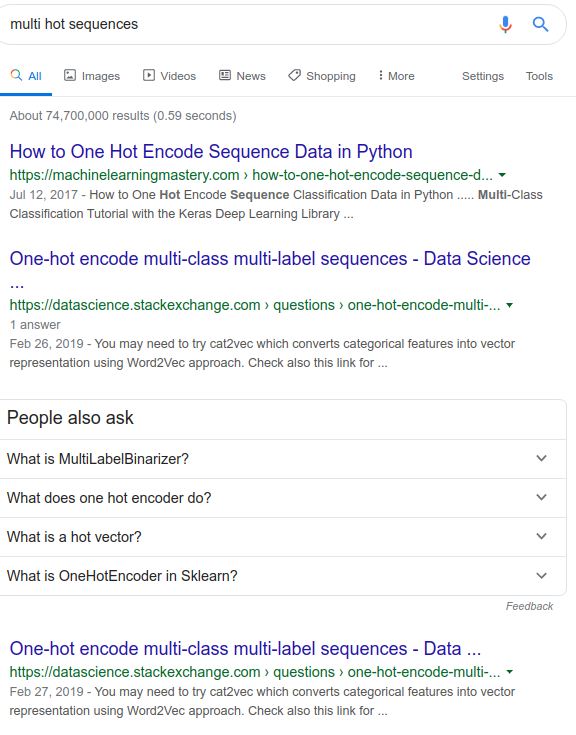

##### Sample Data
A sample of the data is presented below.

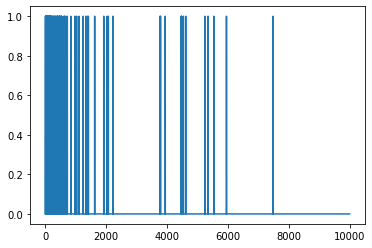

In [51]:
plt.plot(train_data[0])

### Example of Overfitting
TODO: Summarize this in English.
과대적합을 막는 가장 간단한 방법은 모델의 규모를 축소하는 것입니다. 즉, 모델에 있는 학습 가능한 파라미터의 수를 줄입니다(모델 파라미터는 층(layer)의 개수와 층의 유닛(unit) 개수에 의해 결정됩니다). 딥러닝에서는 모델의 학습 가능한 파라미터의 수를 종종 모델의 "용량"이라고 말합니다. 직관적으로 생각해 보면 많은 파라미터를 가진 모델이 더 많은 "기억 용량"을 가집니다. 이런 모델은 훈련 샘플과 타깃 사이를 일반화 능력이 없는 딕셔너리와 같은 매핑으로 완벽하게 학습할 수 있습니다. 하지만 이전에 본 적 없는 데이터에서 예측을 할 땐 쓸모가 없을 것입니다.

항상 기억해야 할 점은 딥러닝 모델이 훈련 세트에는 학습이 잘 되는 경향이 있지만 진짜 해결할 문제는 학습이 아니라 일반화라는 것입니다.

반면에 네트워크의 기억 용량이 부족하다면 이런 매핑을 쉽게 학습할 수 없을 것입니다. 손실을 최소화하기 위해서는 예측 성능이 더 많은 압축된 표현을 학습해야 합니다. 또한 너무 작은 모델을 만들면 훈련 데이터를 학습하기 어렵울 것입니다. "너무 많은 용량"과 "충분하지 않은 용량" 사이의 균형을 잡아야 합니다.

안타깝지만 어떤 모델의 (층의 개수나 뉴런 개수에 해당하는) 적절한 크기나 구조를 결정하는 마법같은 공식은 없습니다. 여러 가지 다른 구조를 사용해 실험을 해봐야만 합니다.

알맞은 모델의 크기를 찾으려면 비교적 적은 수의 층과 파라미터로 시작해서 검증 손실이 감소할 때까지 새로운 층을 추가하거나 층의 크기를 늘리는 것이 좋습니다. 영화 리뷰 분류 네트워크를 사용해 이를 실험해 보죠.

Dense 층만 사용하는 간단한 기준 모델을 만들고 작은 규모의 버전와 큰 버전의 모델을 만들어 비교하겠습니다.

#### Baseline Model
##### Build a 16x16x1 Dense Network

In [53]:
baseline_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


##### Train the Baseline Model

In [54]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.4762 - accuracy: 0.8054 - binary_crossentropy: 0.4762 - val_loss: 0.3235 - val_accuracy: 0.8790 - val_binary_crossentropy: 0.3235
Epoch 2/20
25000/25000 - 1s - loss: 0.2394 - accuracy: 0.9142 - binary_crossentropy: 0.2394 - val_loss: 0.2831 - val_accuracy: 0.8878 - val_binary_crossentropy: 0.2831
Epoch 3/20
25000/25000 - 1s - loss: 0.1774 - accuracy: 0.9368 - binary_crossentropy: 0.1774 - val_loss: 0.2925 - val_accuracy: 0.8832 - val_binary_crossentropy: 0.2925
Epoch 4/20
25000/25000 - 1s - loss: 0.1415 - accuracy: 0.9522 - binary_crossentropy: 0.1415 - val_loss: 0.3138 - val_accuracy: 0.8788 - val_binary_crossentropy: 0.3138
Epoch 5/20
25000/25000 - 1s - loss: 0.1168 - accuracy: 0.9628 - binary_crossentropy: 0.1168 - val_loss: 0.3465 - val_accuracy: 0.8732 - val_binary_crossentropy: 0.3465
Epoch 6/20
25000/25000 - 1s - loss: 0.0974 - accuracy: 0.9696 - binary_crossentropy: 0.0974 - val_loss: 0.3800

### Function to Plot the Learning Curve

In [122]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

def plot_learning_curve( history_dict ):
  '''
  history_dict = history.history
  '''
  accuracy = history_dict.history['accuracy']
  loss = history_dict.history['loss']

  val_accuracy = history_dict.history['val_accuracy']
  val_loss = history_dict.history['val_loss']

  n = range(1, len(loss)+1 )  # n is epochs

  fig = plt.figure(tight_layout=True)
  gs  = gridspec.GridSpec(2, 2)    

  ax = fig.add_subplot(gs[0, :])
  ax.plot( n, accuracy, 'b', label='accuracy' )
  ax.plot( n, val_accuracy, 'r', label='val_accuracy' )
  ax.plot( n, loss, 'b--', label='loss' )
  ax.plot( n, val_loss, 'r--', label='val_loss' )
  ax.set_xlabel('n (epoch)')
  ax.grid()
  ax.legend()

  ax = fig.add_subplot(gs[1, 0])
  #ax.plot( n, loss, 'b.' )
  ax.plot( n, loss, 'b--' )
  #ax.plot( n, val_loss, 'r.' )
  ax.plot( n, val_loss, 'r--' )
  ax.set_xlabel('n (epoch)')
  ax.set_ylabel('loss')
  ax.grid()

  ax = fig.add_subplot(gs[1, 1])
  ax.plot( n, accuracy, 'b.' )
  ax.plot( n, accuracy, 'b', label='Training' )
  ax.plot( n, val_accuracy, 'r.' )
  ax.plot( n, val_accuracy, 'r', label='Validation' )
  ax.set_xlabel('n (epoch)')
  ax.set_ylabel('accuracy')
  ax.grid()

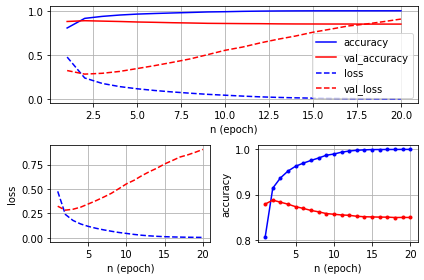

In [123]:
plot_learning_curve( baseline_history )

### Make a Smaller Model than the Baseline
The capacity of this network or the number of weights is smaller than that of the baseline network.

In [55]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

#### Build or Compile the Network

In [56]:
smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


##### Train the Network

In [57]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6317 - accuracy: 0.6551 - binary_crossentropy: 0.6317 - val_loss: 0.5760 - val_accuracy: 0.7606 - val_binary_crossentropy: 0.5760
Epoch 2/20
25000/25000 - 1s - loss: 0.5304 - accuracy: 0.8034 - binary_crossentropy: 0.5304 - val_loss: 0.5173 - val_accuracy: 0.8164 - val_binary_crossentropy: 0.5173
Epoch 3/20
25000/25000 - 1s - loss: 0.4740 - accuracy: 0.8624 - binary_crossentropy: 0.4740 - val_loss: 0.4832 - val_accuracy: 0.8276 - val_binary_crossentropy: 0.4832
Epoch 4/20
25000/25000 - 1s - loss: 0.4339 - accuracy: 0.8918 - binary_crossentropy: 0.4339 - val_loss: 0.4623 - val_accuracy: 0.8424 - val_binary_crossentropy: 0.4623
Epoch 5/20
25000/25000 - 1s - loss: 0.4026 - accuracy: 0.9132 - binary_crossentropy: 0.4026 - val_loss: 0.4432 - val_accuracy: 0.8631 - val_binary_crossentropy: 0.4432
Epoch 6/20
25000/25000 - 1s - loss: 0.3772 - accuracy: 0.9289 - binary_crossentropy: 0.3772 - val_loss: 0.4357

### Plot the Learning Curve for the Smaller Network

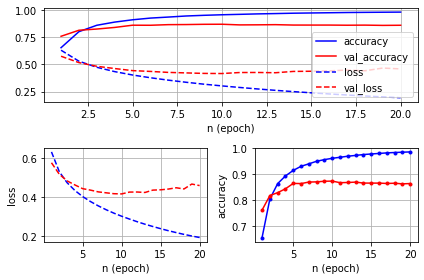

In [124]:
plot_learning_curve( smaller_history )

### Build a Bigger Model than the Baseline
Let's see how quickly overfitting can occur with a very large model. This bigger model's capacity is a lot larger than what this problem requires.

In [62]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


#### Train the Bigger Model

In [63]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.3409 - accuracy: 0.8538 - binary_crossentropy: 0.3409 - val_loss: 0.2959 - val_accuracy: 0.8798 - val_binary_crossentropy: 0.2959
Epoch 2/20
25000/25000 - 3s - loss: 0.1375 - accuracy: 0.9493 - binary_crossentropy: 0.1375 - val_loss: 0.3310 - val_accuracy: 0.8728 - val_binary_crossentropy: 0.3310
Epoch 3/20
25000/25000 - 3s - loss: 0.0461 - accuracy: 0.9870 - binary_crossentropy: 0.0461 - val_loss: 0.4469 - val_accuracy: 0.8688 - val_binary_crossentropy: 0.4469
Epoch 4/20
25000/25000 - 3s - loss: 0.0063 - accuracy: 0.9990 - binary_crossentropy: 0.0063 - val_loss: 0.5797 - val_accuracy: 0.8705 - val_binary_crossentropy: 0.5797
Epoch 5/20
25000/25000 - 3s - loss: 0.0019 - accuracy: 0.9999 - binary_crossentropy: 0.0019 - val_loss: 0.6710 - val_accuracy: 0.8714 - val_binary_crossentropy: 0.6710
Epoch 6/20
25000/25000 - 3s - loss: 2.7686e-04 - accuracy: 1.0000 - binary_crossentropy: 2.7686e-04 - val_loss

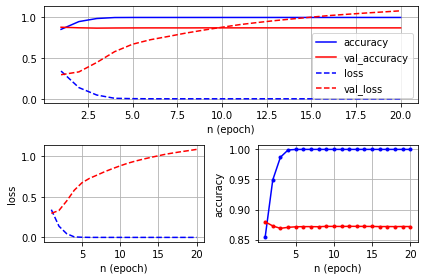

In [125]:
plot_learning_curve( bigger_history )

### Compare the Learning Curves of All Three Models

In [168]:
def compare_learning_curves3( hist_dict1, hist_dict2, hist_dict3, titles=False ):
  '''
  history_dict = history.history
  '''
  accuracy1 = hist_dict1.history['accuracy']
  val_accuracy1 = hist_dict1.history['val_accuracy']
  loss1 = hist_dict1.history['loss']
  val_loss1 = hist_dict1.history['val_loss']

  n = range(1, len(loss1)+1 )  # n is epochs

  fig = plt.figure(tight_layout=True)
  gs  = gridspec.GridSpec(1, 3)    

  ax = fig.add_subplot(gs[0, 0])
  ax.plot( n, accuracy1, 'b', label='accuracy' )
  ax.plot( n, val_accuracy1, 'r', label='val_accuracy' )
  ax.plot( n, loss1, 'b--', label='loss' )
  ax.plot( n, val_loss1, 'r--', label='val_loss' )
  ax.set_xlabel('n (epoch)')
  ax.grid()
  ax.legend()
  if titles:
   ax.set_title( titles[0] )

  accuracy2 = hist_dict2.history['accuracy']
  val_accuracy2 = hist_dict2.history['val_accuracy']
  loss2 = hist_dict2.history['loss']
  val_loss2 = hist_dict2.history['val_loss']

  ax = fig.add_subplot(gs[0, 1])
  ax.plot( n, accuracy2, 'b', label='accuracy' )
  ax.plot( n, val_accuracy2, 'r', label='val_accuracy' )
  ax.plot( n, loss2, 'b--', label='loss' )
  ax.plot( n, val_loss2, 'r--', label='val_loss' )
  ax.set_xlabel('n (epoch)')
  ax.grid()
  if titles:
   ax.set_title( titles[1] )

  accuracy3 = hist_dict3.history['accuracy']
  val_accuracy3 = hist_dict3.history['val_accuracy']
  loss3 = hist_dict3.history['loss']
  val_loss3 = hist_dict3.history['val_loss']

  ax = fig.add_subplot(gs[0, 2])
  ax.plot( n, accuracy3, 'b', label='accuracy' )
  ax.plot( n, val_accuracy3, 'r', label='val_accuracy' )
  ax.plot( n, loss3, 'b--', label='loss' )
  ax.plot( n, val_loss3, 'r--', label='val_loss' )
  ax.set_xlabel('n (epoch)')
  ax.grid()
  if titles:
   ax.set_title( titles[2] )

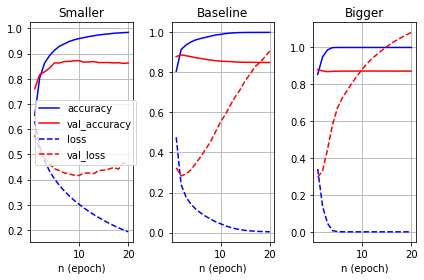

In [169]:
compare_learning_curves3( smaller_history, baseline_history, bigger_history, titles=['Smaller', 'Baseline', 'Bigger'] )

compare_learning_curves_old is another type of plot.

In [147]:
def compare_learning_curves_old( hist_dict1, hist_dict2, hist_dict3 ):
  '''
  history_dict = history.history
  '''
  accuracy1 = hist_dict1.history['accuracy']
  loss1 = hist_dict1.history['loss']

  n = range(1, len(loss1)+1 )  # n is epochs

  plt.subplot(1,3,1)
  plt.plot( n, accuracy1, 'b', label='Accuracy' )
  plt.plot( n, loss1, 'r', label='Loss' )
  plt.title('Smaller')
  plt.xlabel('n (epoch)')
  plt.grid()
  plt.legend()

  accuracy2 = hist_dict2.history['accuracy']
  loss2 = hist_dict2.history['loss']
    
  plt.subplot(1,3,2)
  plt.plot( n, accuracy2, 'b', label='Accuracy' )
  plt.plot( n, loss2, 'r', label='Loss' )
  plt.title('Baseline')
  plt.xlabel('n (epoch)')
  plt.grid()

  accuracy3 = hist_dict3.history['accuracy']
  loss3 = hist_dict3.history['loss']
    
  plt.subplot(1,3,3)
  plt.plot( n, accuracy3, 'b', label='Accuracy' )
  plt.plot( n, loss3, 'r', label='Loss' )
  plt.title('Bigger')
  plt.xlabel('n (epoch)')
  plt.grid()
  
  plt.tight_layout()
  plt.show()

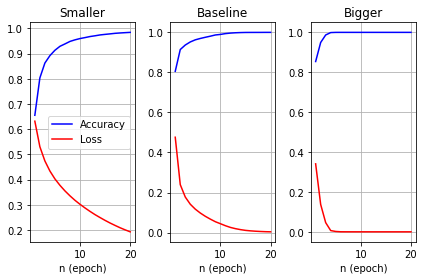

In [148]:
compare_learning_curves_old( smaller_history, baseline_history, bigger_history )

The bigger model's accuracy increases and the loss also decreases quicker than the rest of them.

### Plot the Training Loss and Validation Loss

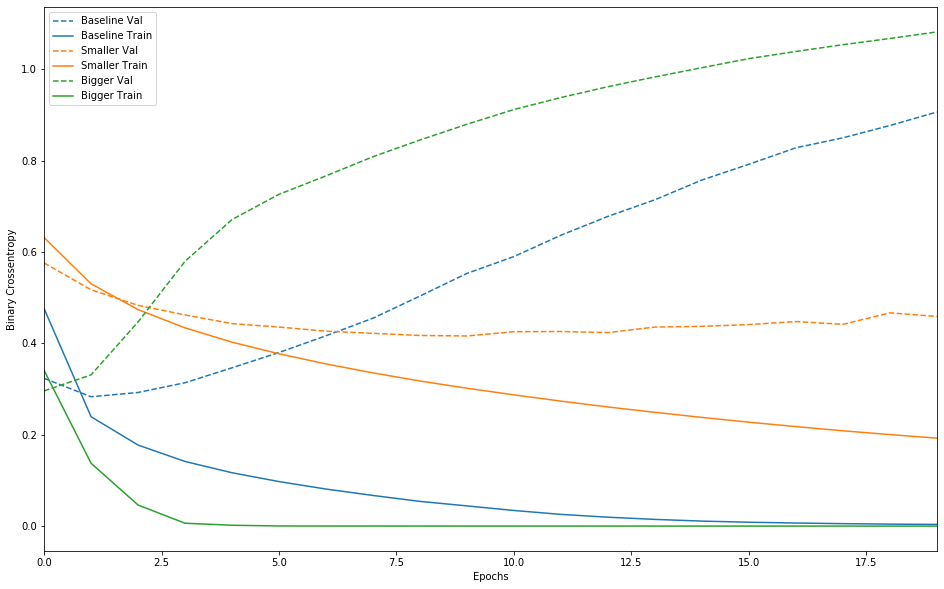

In [149]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

실선은 훈련 손실이고 점선은 검증 손실입니다(낮은 검증 손실이 더 좋은 모델입니다). 여기서는 작은 네트워크가 기준 모델보다 더 늦게 과대적합이 시작되었습니다(즉 에포크 4가 아니라 6에서 시작됩니다). 또한 과대적합이 시작되고 훨씬 천천히 성능이 감소합니다.

큰 네트워크는 거의 바로 첫 번째 에포크 이후에 과대적합이 시작되고 훨씬 더 심각하게 과대적합됩니다. 네트워크의 용량이 많을수록 훈련 세트를 더 빠르게 모델링할 수 있습니다(훈련 손실이 낮아집니다). 하지만 더 쉽게 과대적합됩니다(훈련 손실과 검증 손실 사이에 큰 차이가 발생합니다).

### Strategies to Prevent Overfitting
#### Regularize the Weights
```python
kernel_regularizer=keras.regularizers.l2(0.001)
```
l2(0.001)는 네트워크의 전체 손실에 층에 있는 가중치 행렬의 모든 값이 0.001 * weight_coefficient_value**2만큼 더해진다는 의미입니다. 이런 페널티(penalty)는 훈련할 때만 추가됩니다. 따라서 테스트 단계보다 훈련 단계에서 네트워크 손실이 훨씬 더 클 것입니다.

```
아마도 오캄의 면도날(Occam's Razor) 이론을 들어 보았을 것입니다. 어떤 것을 설명하는 두 가지 방법이 있다면 더 정확한 설명은 최소한의 가정이 필요한 가장 "간단한" 설명일 것입니다. 이는 신경망으로 학습되는 모델에도 적용됩니다. 훈련 데이터와 네트워크 구조가 주어졌을 때 이 데이터를 설명할 수 있는 가중치의 조합(즉, 가능한 모델)은 많습니다. 간단한 모델은 복잡한 것보다 과대적합되는 경향이 작을 것입니다.

여기서 "간단한 모델"은 모델 파라미터의 분포를 봤을 때 엔트로피(entropy)가 작은 모델입니다(또는 앞 절에서 보았듯이 적은 파라미터를 가진 모델입니다). 따라서 과대적합을 완화시키는 일반적인 방법은 가중치가 작은 값을 가지도록 네트워크의 복잡도에 제약을 가하는 것입니다. 이는 가중치 값의 분포를 좀 더 균일하게 만들어 줍니다. 이를 "가중치 규제"(weight regularization)라고 부릅니다. 네트워크의 손실 함수에 큰 가중치에 해당하는 비용을 추가합니다. 이 비용은 두 가지 형태가 있습니다:

L1 규제는 가중치의 절댓값에 비례하는 비용이 추가됩니다(즉, 가중치의 "L1 노름(norm)"을 추가합니다).

L2 규제는 가중치의 제곱에 비례하는 비용이 추가됩니다(즉, 가중치의 "L2 노름"의 제곱을 추가합니다). 신경망에서는 L2 규제를 가중치 감쇠(weight decay)라고도 부릅니다. 이름이 다르지만 혼돈하지 마세요. 가중치 감쇠는 수학적으로 L2 규제와 동일합니다.

L1 규제는 일부 가중치 파라미터를 0으로 만듭니다. L2 규제는 가중치 파라미터를 제한하지만 완전히 0으로 만들지는 않습니다. 이것이 L2 규제를 더 많이 사용하는 이유 중 하나입니다.
```

In [150]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.5203 - accuracy: 0.8060 - binary_crossentropy: 0.4799 - val_loss: 0.3751 - val_accuracy: 0.8790 - val_binary_crossentropy: 0.3335
Epoch 2/20
25000/25000 - 1s - loss: 0.2988 - accuracy: 0.9124 - binary_crossentropy: 0.2536 - val_loss: 0.3326 - val_accuracy: 0.8883 - val_binary_crossentropy: 0.2847
Epoch 3/20
25000/25000 - 1s - loss: 0.2475 - accuracy: 0.9315 - binary_crossentropy: 0.1971 - val_loss: 0.3373 - val_accuracy: 0.8863 - val_binary_crossentropy: 0.2850
Epoch 4/20
25000/25000 - 1s - loss: 0.2242 - accuracy: 0.9419 - binary_crossentropy: 0.1702 - val_loss: 0.3497 - val_accuracy: 0.8817 - val_binary_crossentropy: 0.2944
Epoch 5/20
25000/25000 - 1s - loss: 0.2101 - accuracy: 0.9490 - binary_crossentropy: 0.1534 - val_loss: 0.3653 - val_accuracy: 0.8783 - val_binary_crossentropy: 0.3075
Epoch 6/20
25000/25000 - 1s - loss: 0.1993 - accuracy: 0.9519 - binary_crossentropy: 0.1406 - val_loss: 0.3813

##### Effect of the L2 Regularization

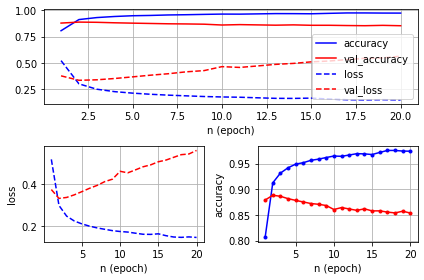

In [151]:
plot_learning_curve( l2_model_history )

It is hard to see the effect of the L2 regularization. So let's compare the baseline network and the one with L2 regularization.

In [163]:
def compare_learning_curves2( hist_dict1, hist_dict2 ):
  '''
  history_dict = history.history
  '''
  accuracy1 = hist_dict1.history['accuracy']
  val_accuracy1 = hist_dict1.history['val_accuracy']
  loss1 = hist_dict1.history['loss']
  val_loss1 = hist_dict1.history['val_loss']

  n = range(1, len(loss1)+1 )  # n is epochs

  fig = plt.figure(tight_layout=True)
  gs  = gridspec.GridSpec(1, 2)    

  ax = fig.add_subplot(gs[0, 0])
  ax.plot( n, accuracy1, 'b', label='accuracy' )
  ax.plot( n, val_accuracy1, 'r', label='val_accuracy' )
  ax.plot( n, loss1, 'b--', label='loss' )
  ax.plot( n, val_loss1, 'r--', label='val_loss' )
  ax.set_title('Baseline')
  ax.set_xlabel('n (epoch)')
  ax.grid()
  ax.legend()

  accuracy2 = hist_dict2.history['accuracy']
  val_accuracy2 = hist_dict2.history['val_accuracy']
  loss2 = hist_dict2.history['loss']
  val_loss2 = hist_dict2.history['val_loss']

  ax = fig.add_subplot(gs[0, 1])
  ax.plot( n, accuracy2, 'b', label='accuracy' )
  ax.plot( n, val_accuracy2, 'r', label='val_accuracy' )
  ax.plot( n, loss2, 'b--', label='loss' )
  ax.plot( n, val_loss2, 'r--', label='val_loss' )
  #ax.set_title('L2-Regularized Baseline')
  ax.set_xlabel('n (epoch)')
  ax.grid()

The graph on the left is the baseline; the one on the right is with L2 regularization.

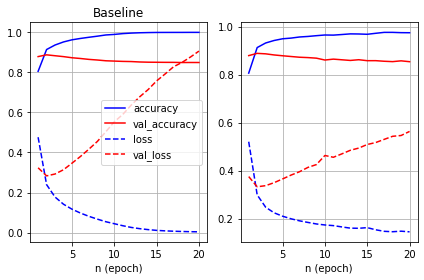

In [164]:
compare_learning_curves2( baseline_history, l2_model_history )

Two of them are depicted in a single graph.

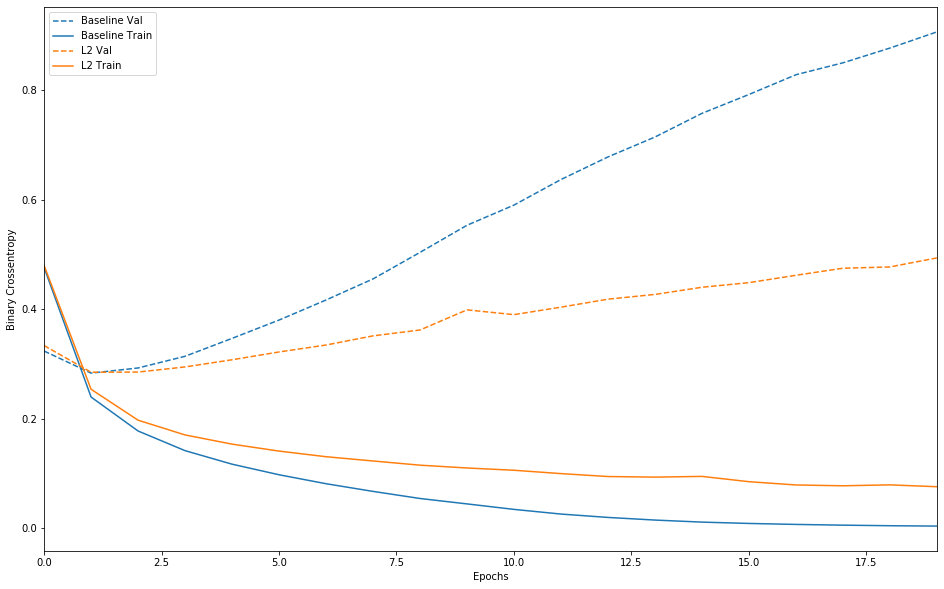

In [160]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

The training loss with regularization is slightly higher than the baseline case. But the validation loss with regularization is a lot smaller than the baseline case. So we may say ***the training is sacrified with the L2 regularization, but the sacrifice gained the reduced validation loss.***

### Dropout
```python
keras.layers.Dropout(0.5)
```
add dropout with 0.5 probability.

```
드롭아웃(dropout)은 신경망에서 가장 효과적이고 널리 사용하는 규제 기법 중 하나입니다. 토론토(Toronto) 대학의 힌튼(Hinton)과 그의 제자들이 개발했습니다. 드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 끕니다(즉, 0으로 만듭니다). 훈련하는 동안 어떤 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1] 벡터를 출력하는 층이 있다고 가정해 보죠. 드롭아웃을 적용하면 이 벡터에서 몇 개의 원소가 랜덤하게 0이 됩니다. 예를 들면, [0, 0.5, 1.3, 0, 1.1]가 됩니다. "드롭아웃 비율"은 0이 되는 특성의 비율입니다. 보통 0.2에서 0.5 사이를 사용합니다. 테스트 단계에서는 어떤 유닛도 드롭아웃하지 않습니다. 훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄입니다.
```

In [161]:
dropout_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

dropout_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dropout_model_history = dropout_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6312 - accuracy: 0.6317 - binary_crossentropy: 0.6312 - val_loss: 0.4879 - val_accuracy: 0.8442 - val_binary_crossentropy: 0.4879
Epoch 2/20
25000/25000 - 1s - loss: 0.4608 - accuracy: 0.7995 - binary_crossentropy: 0.4608 - val_loss: 0.3311 - val_accuracy: 0.8802 - val_binary_crossentropy: 0.3311
Epoch 3/20
25000/25000 - 1s - loss: 0.3450 - accuracy: 0.8650 - binary_crossentropy: 0.3450 - val_loss: 0.2836 - val_accuracy: 0.8866 - val_binary_crossentropy: 0.2836
Epoch 4/20
25000/25000 - 1s - loss: 0.2798 - accuracy: 0.8955 - binary_crossentropy: 0.2798 - val_loss: 0.2736 - val_accuracy: 0.8898 - val_binary_crossentropy: 0.2736
Epoch 5/20
25000/25000 - 1s - loss: 0.2383 - accuracy: 0.9152 - binary_crossentropy: 0.2383 - val_loss: 0.2767 - val_accuracy: 0.8875 - val_binary_crossentropy: 0.2767
Epoch 6/20
25000/25000 - 1s - loss: 0.2036 - accuracy: 0.9299 - binary_crossentropy: 0.2036 - val_loss: 0.2917

Compare the baseline and the dropout models.

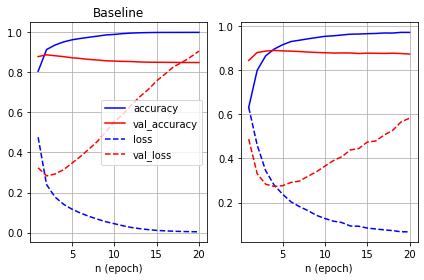

In [165]:
compare_learning_curves2( baseline_history, dropout_model_history )

Dropout improves the validation loss dramatically while the validation accuracy is slightly better than the baseline.

### Comparision: Baseline, L2 Regularization, and Dropout
The three cases are compared below.

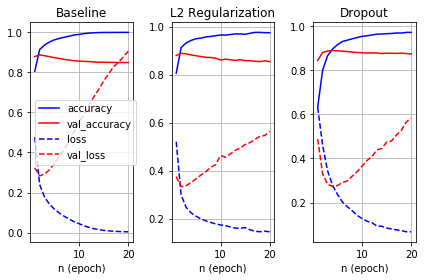

In [170]:
compare_learning_curves3( baseline_history, l2_model_history, dropout_model_history, titles=['Baseline', 'L2 Regularization', 'Dropout'] )

## Summary
```
정리하면 신경망에서 과대적합을 방지하기 위해 가장 널리 사용하는 방법은 다음과 같습니다:

더 많은 훈련 데이터를 모읍니다.
네트워크의 용량을 줄입니다.
가중치 규제를 추가합니다.
드롭아웃을 추가합니다.

이 문서에서 다루지 않은 중요한 방법 두 가지는 데이터 증식(data-augmentation)과 배치 정규화(batch normalization)입니다.
```

(EOF)